In [3]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, auc, RocCurveDisplay
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [4]:
colors = ["#D8E8E8", "#A8D0DA", "#406D96", "#2F3A56", "#E2474B"]
sns.set_palette(sns.color_palette(colors))

In [5]:
df = pd.read_csv('../data/preprocessed_train.csv', encoding='utf-8')
df.head()

,title,author,text,label,removed_punc,tokens,filtered_tokens,clean_tokens,lemma_words,clean_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide We Didn’t Even See Comey’s Lett...,"['house', 'dem', 'aide', 'we', 'didn’t', 'even...","['house', 'aide', 'didn’t', 'even', 'comey’s',...","['house', 'aide', 'didn’t', 'even', 'comey’s',...","['house', 'aide', 'didn’t', 'even', 'comey’s',...",house aide didn’t even comey’s letter jason ch...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,Ever get the feeling your life circles the rou...,"['ever', 'get', 'the', 'feeling', 'your', 'lif...","['ever', 'feeling', 'your', 'life', 'circles',...","['ever', 'feeling', 'life', 'circles', 'rounda...","['ever', 'feeling', 'life', 'circle', 'roundab...",ever feeling life circle roundabout rather hea...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired October 29 2...,"['why', 'the', 'truth', 'might', 'get', 'you',...","['truth', 'might', 'fired', 'october', '2016',...","['truth', 'might', 'fired', 'october', '2016',...","['truth', 'might', 'fired', 'october', '2016',...",truth might fired october 2016 tension intelli...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Videos 15 Civilians Killed In Single US Airstr...,"['videos', '15', 'civilians', 'killed', 'in', ...","['videos', 'civilians', 'killed', 'single', 'a...","['videos', 'civilians', 'killed', 'single', 'a...","['video', 'civilian', 'killed', 'single', 'air...",video civilian killed single airstrike identif...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1,Print \r\nAn Iranian woman has been sentenced ...,"['print', 'an', 'iranian', 'woman', 'has', 'be...","['print', 'iranian', 'woman', 'been', 'sentenc...","['print', 'iranian', 'woman', 'sentenced', 'ye...","['print', 'iranian', 'woman', 'sentenced', 'ye...",print iranian woman sentenced year prison iran...


In [6]:
df = df.dropna()

In [55]:
X = df['clean_text']
y = df['label']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 5)

In [42]:
X_train.isna().sum()

0

In [43]:
print(X_train.shape)
print(X_test.shape)

(14533,)
(3634,)


In [44]:
X_train

4447     Obama Just Did Something To Spite Trump On The...
17400    James Ellroy’s “American Tabloid” – Film, Lite...
15251    Before The Great Flood 8 Kings Ruled Earth For...
7016     Jeff Sessions on Immigration Law: ’I’m Going t...
5800     Medicare and Social Security Trustees Warn of ...
                               ...                        
745      NOT OVER: FBI To Conduct New Investigation Of ...
1041     Comment on Clinton Campaign Memo: “Let’s Troll...
5545     ESPN Gives Tim Tebow a Contract Extension - Br...
3062     #PodestaEmails20: WikiLeaks releases another b...
2931     What the Trump Presidency Means for the Suprem...
Name: title, Length: 14533, dtype: object

In [57]:
tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

print(tfidf_train.toarray())
print(tfidf_train.shape)
print(tfidf_test.toarray())
print(tfidf_test.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(14533, 148708)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(3634, 148708)


In [13]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [14]:
def plot_roc_cv(model):
    # Run classifier with cross-validation and plot ROC curves
    cv = KFold(n_splits=5, random_state=42, shuffle=True)


    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(tfidf_train, y_train)):
        model.fit(tfidf_train[train], y_train.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            model,
            tfidf_train[test],
            y_train.iloc[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=colors[3],
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        cmap=ListedColormap(colors),
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        # title="ROC Curve",
    )
    ax.legend(loc="lower right")
    plt.show()

## XGBClassifier

In [48]:
xgb = XGBClassifier()
xgb.fit(tfidf_train, y_train)

pred = xgb.predict(tfidf_test)
cm = confusion_matrix(y_test, pred)

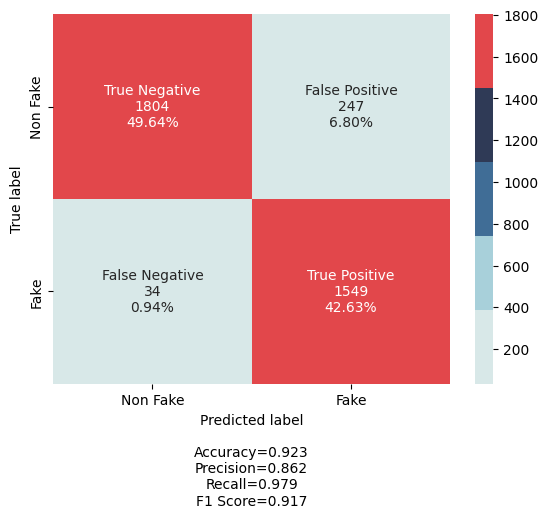

In [49]:
make_confusion_matrix(cm, 
                      group_names=['True Negative','False Positive','False Negative','True Positive'],
                      categories=['Non Fake', 'Fake'], 
                      cmap=ListedColormap(colors))

In [ ]:
plot_roc_cv(xgb)

## Adaboost

In [23]:
class DecisionStump:
    def __init__(self):
        self.polarity = 1       # polarity of the stump (+1 or -1)
        self.feature_idx = None # index of feature used for splitting
        self.threshold = None   # threshold value for splitting
        self.alpha = None       # weight of the stump in the final [strong] classifier

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]

        predictions = np.ones(n_samples) # initialize all predictions to 1

        # determine what side of the split will be marked as -1 depending on the polarity of the stump
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions


class Adaboost:
    def __init__(self, n_clf = 5):
        self.n_clf = n_clf # number of [weak] classifiers
        self.clfs = []     # list of classifiers

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        # Iterate through classifiers
        for _ in range(self.n_clf):

            # create a new classifier
            clf = DecisionStump()
            min_error = float("inf")

            # greedy search to find best threshold and feature (ie. the one that minimizes error)
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column) # get unique values in the column of the current feature

                for threshold in thresholds:
                    # predict with polarity 1
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1 # values to the left of the split are marked as -1

                    # Error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = np.sum(misclassified)

                    # since error is a value between 0 and 1, change the polarity of the prediction if the stump is
                    # misclassifying more than half of the weighted samples (ie. make it predict the other way around)
                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # store the best stump parameters found so far
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate alpha, and use EPS to avoid division by zero
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # calculate predictions and update weights
            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w) # normalize the weights so that they sum up to 1

            # save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

In [17]:
# # Adaboost assumes that the labels are -1 and 1, so we need to change the 0s to -1s
# y_train[y_train == 0] = -1
# y_test[y_test == 0] = -1

# clf = Adaboost(n_clf=5)
# clf.fit(tfidf_train.toarray(), y_train)

# pred = clf.predict(tfidf_test.toarray())
# cm = confusion_matrix(y_test, pred)

In [65]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_classifier = DecisionTreeClassifier(max_depth=1)

# Creating an AdaBoost classifier with 100 weak classifiers
clf = AdaBoostClassifier(base_classifier, n_estimators=100, random_state=42)

# Fitting the classifier to the training data
clf.fit(tfidf_train, y_train)

# Predicting on the test data
pred = clf.predict(tfidf_test)

# Calculating confusion matrix
cm = confusion_matrix(y_test, pred)


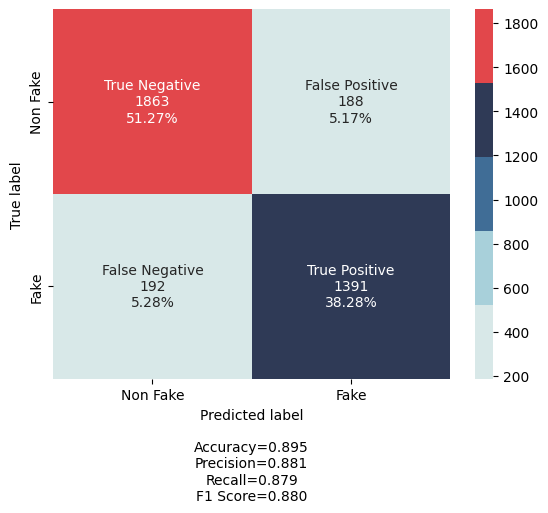

In [66]:
make_confusion_matrix(cm, 
                      group_names=['True Negative','False Positive','False Negative','True Positive'],
                      categories=['Non Fake', 'Fake'], 
                      cmap=ListedColormap(colors))

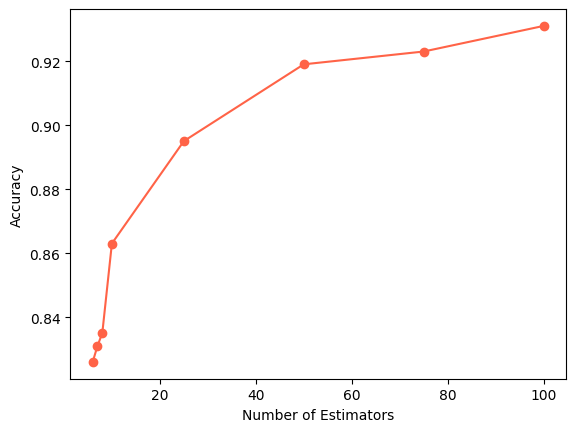

In [69]:

n_estimators_values = [6, 7, 8, 10, 25, 50, 75, 100]
accuracies = [0.826, 0.831, 0.835, 0.863, 0.895, 0.919, 0.923, 0.931]

plt.plot(n_estimators_values, accuracies, marker='o', color="tomato")

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')

plt.show()

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Creating a RandomForest classifier with 5 trees
rf_classifier = RandomForestClassifier(random_state=42)

# Fitting the classifier to the training data
rf_classifier.fit(tfidf_train, y_train)

# Predicting on the test data
rf_pred = rf_classifier.predict(tfidf_test)

# Calculating confusion matrix
rf_cm = confusion_matrix(y_test, rf_pred)

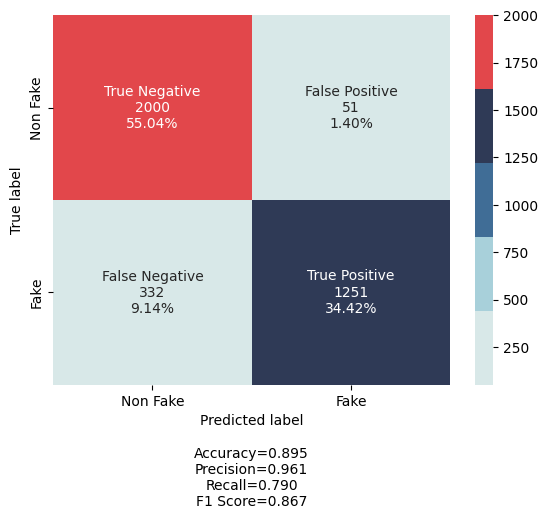

In [21]:
make_confusion_matrix(rf_cm, 
                      group_names=['True Negative','False Positive','False Negative','True Positive'],
                      categories=['Non Fake', 'Fake'], 
                      cmap=ListedColormap(colors))

## Submission

In [22]:
# test_df = pd.read_csv('../data/test.csv', encoding='utf-8')
# test_df

In [23]:
# class Preprocessing:
#     def __init__(self, df):
#         self._df = df
    
#     def _set_dtypes(self):
#         self._df['author'][self._df['author'].notna()] = self._df['author'].astype('str')
#         self._df['title'][self._df['title'].notna()] = self._df['title'].astype('str')
#         self._df['text'][self._df['text'].notna()] = self._df['text'].astype('str')
    
#     def _remove_duplicates(self):
#         self._df = self._df.drop_duplicates()

#     def _remove_empty_rows(self):
#         self._df = self._df.dropna(subset=['title', 'author', 'text'])

#     def _remove_punctuation(self):
#         self._df['removed_punc'] = self._df['text'].apply(lambda x: ("".join([ch for ch in x if ch not in string.punctuation])))

#     def _tokenize(self, col_name='removed_punc'):
#         # We use the WhitespaceTokenizer to not separate the words with contractions (i.e keep don't, didn't, etc. as one token)
#         self._df['tokens'] = self._df[col_name].apply(lambda x: nltk.WhitespaceTokenizer().tokenize(x.lower()))
    
#     def _remove_short_words(self, col_name='tokens', min_len=3):
#         self._df['filtered_tokens'] = self._df[col_name].apply(lambda x: [word for word in x if len(word) > min_len])

#     def _remove_stop_words(self, col_name='filtered_tokens'):
#         self._df['clean_tokens'] = self._df[col_name].apply(lambda x: [word for word in x if word not in (nltk.corpus.stopwords.words('english'))])

#     def _lemmatize(self, col_name='clean_tokens'):
#         self._df['lemma_words'] = self._df[col_name].apply(lambda x : [nltk.WordNetLemmatizer().lemmatize(word) for word in x])

#     def _clean_text(self, col_name='lemma_words'):
#         self._df['clean_text'] = self._df[col_name].apply(lambda x : " ".join([word for word in x]))

#     def preprocess(self):
#         # self._set_dtypes()
#         self._remove_punctuation()
#         self._tokenize()
#         self._remove_short_words()
#         self._remove_stop_words()
#         self._lemmatize()
#         self._clean_text()
        
#         return self._df

In [24]:
# def preprocess(df):
#     preprocessing = Preprocessing(df)
#     df = preprocessing.preprocess()
#     return df

In [25]:
# test_df.shape

In [26]:
# test_df_id = test_df['id']
# test_df_id

In [27]:
# test_df = test_df.drop(['title','id','author'],axis=1)
# test_df.shape

In [28]:
# test_df.fillna('fake fake fake',inplace=True)

In [29]:
# test_df = preprocess(test_df)
# test_df

In [30]:
# test_df['clean_text']

In [31]:
# tfidf_test2 = tfidf.transform(test_df['clean_text'])
# tfidf_test2.shape

In [32]:
# check = xgb.predict(tfidf_test2)
# check.shape

In [33]:
# val = []
# for i in check:
#     val.append(i)

In [34]:
# submission = pd.DataFrame({'id': test_df_id, 'label':val})
# submission

In [35]:
# submission.to_csv('submission.csv',index=False)

# Title vs clean_text metrics

In [50]:
title_metrics = {
    'AdaBoostClassifier': {
        'Accuracy': 0.921,
        'F1 Score': 0.914,
        'Precision': 0.871,
        'Recall': 0.961
    },
    'XGBClassifier': {
        'Accuracy': 0.923,
        'F1 Score': 0.917,
        'Precision': 0.862,
        'Recall': 0.979
    },
    'RandomForestClassifier': {
        'Accuracy': 0.929,
        'F1 Score': 0.923,
        'Precision': 0.874,
        'Recall': 0.979
    }
}

In [51]:
df_title = pd.DataFrame.from_dict({(i, j): title_metrics[i][j] for i in title_metrics.keys() for j in title_metrics[i].keys()}, orient='index')
df_title.index = pd.MultiIndex.from_tuples(df_title.index, names=['Model', 'Metric'])
df_title.columns = ['Value']
df_title

Value
Model                  Metric          
AdaBoostClassifier     Accuracy   0.921
                       F1 Score   0.914
                       Precision  0.871
                       Recall     0.961
XGBClassifier          Accuracy   0.923
                       F1 Score   0.917
                       Precision  0.862
                       Recall     0.979
RandomForestClassifier Accuracy   0.929
                       F1 Score   0.923
                       Precision  0.874
                       Recall     0.979

In [52]:
clean_text_metrics = {
    'AdaBoostClassifier': {
        'Accuracy': 0.931,
        'F1 Score': 0.921,
        'Precision': 0.923,
        'Recall': 0.919
    },
    'XGBClassifier': {
        'Accuracy': 0.951,
        'F1 Score': 0.944,
        'Precision': 0.947,
        'Recall': 0.941
    },
    'RandomForestClassifier': {
        'Accuracy': 0.895,
        'F1 Score': 0.867,
        'Precision': 0.961,
        'Recall': 0.790
    }
}

In [53]:
df_clean_text = pd.DataFrame.from_dict({(i, j): clean_text_metrics[i][j] for i in clean_text_metrics.keys() for j in clean_text_metrics[i].keys()}, orient='index')
df_clean_text.index = pd.MultiIndex.from_tuples(df_clean_text.index, names=['Model', 'Metric'])
df_clean_text.columns = ['Value']
df_clean_text

Value
Model                  Metric          
AdaBoostClassifier     Accuracy   0.931
                       F1 Score   0.921
                       Precision  0.923
                       Recall     0.919
XGBClassifier          Accuracy   0.951
                       F1 Score   0.944
                       Precision  0.947
                       Recall     0.941
RandomForestClassifier Accuracy   0.895
                       F1 Score   0.867
                       Precision  0.961
                       Recall     0.790

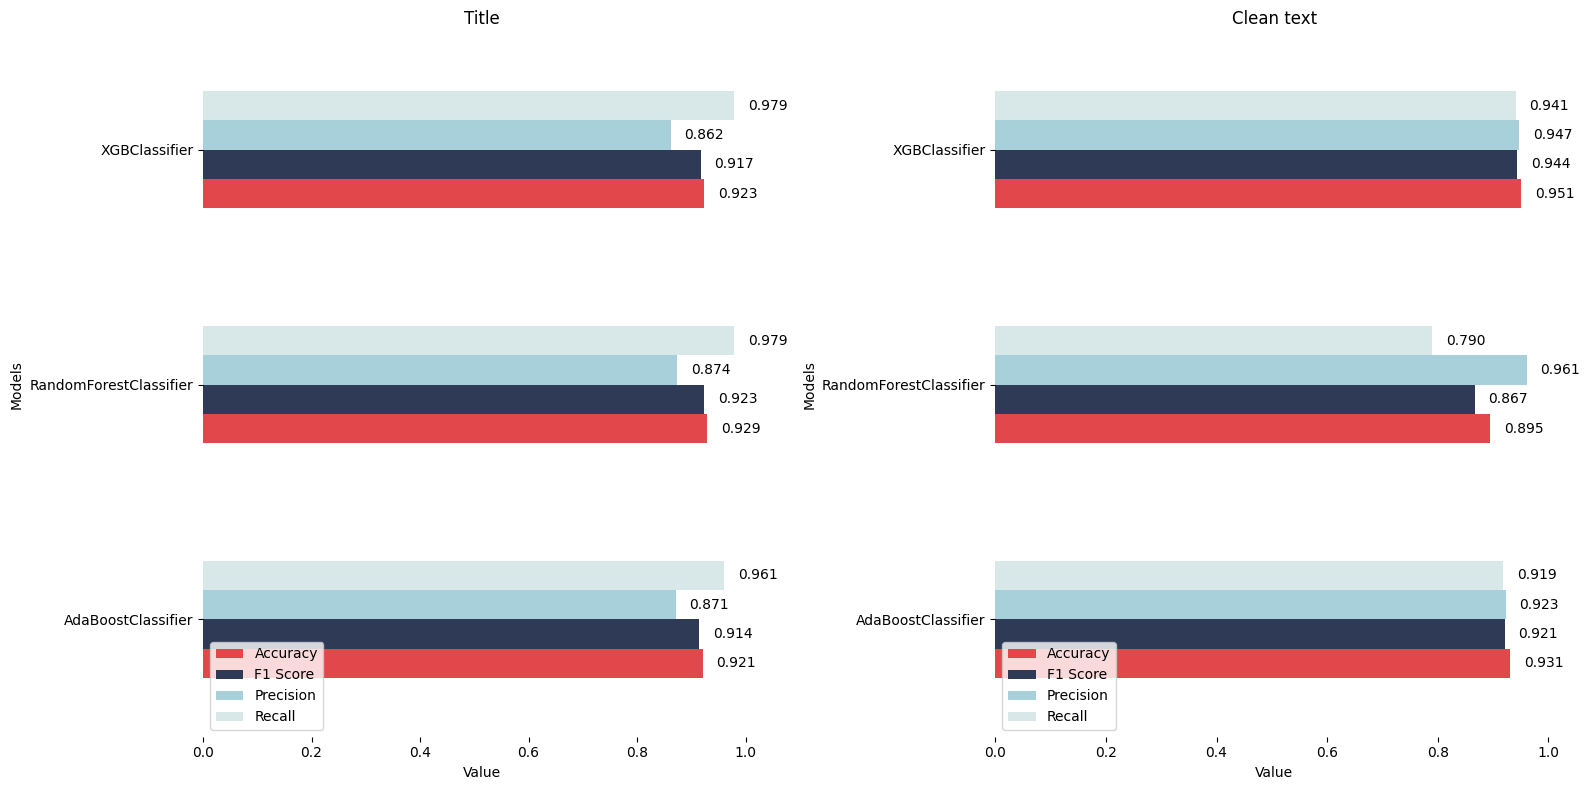

In [54]:
# Configurar el tamaño y diseño de los subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Primer subplot para el análisis de títulos
df_title_unstacked = df_title.unstack(level='Model')
df_title_unstacked.columns = df_title_unstacked.columns.droplevel()
df_title_unstacked = df_title_unstacked.transpose()
ax = df_title_unstacked.plot(kind='barh', stacked=False, colormap=ListedColormap(colors[::-1]), ax=axes[0])

for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(10, 0), textcoords='offset points')



# Configurar el título y las etiquetas del primer subplot
axes[0].set_title('Title')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Models')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].legend(df_title.index.get_level_values(1).unique(), loc='lower left')

# Segundo subplot para el análisis de contenido
df_clean_text_unstacked = df_clean_text.unstack(level='Model')
df_clean_text_unstacked.columns = df_clean_text_unstacked.columns.droplevel()
df_clean_text_unstacked = df_clean_text_unstacked.transpose()
ax = df_clean_text_unstacked.plot(kind='barh', stacked=False, colormap=ListedColormap(colors[::-1]), ax=axes[1])

for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(10, 0), textcoords='offset points')



# Configurar el título y las etiquetas del segundo subplot
axes[1].set_title('Clean text')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Models')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].legend(df_clean_text.index.get_level_values(1).unique(), loc='lower left')

# Ajustar el diseño para evitar solapamiento
plt.tight_layout()
# Mostrar los subplots
plt.show()